# full scene segment eda

This is the initial exploration into the full scene segmentation data

In [3]:
! ls /cs-share/pradalier/tmp/judo

frame_files.txt  frames  fullframe_inference  timer  yolo_segmentation_runs


In [4]:
from IPython.display import display

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

root = Path("/cs-share/pradalier/tmp/judo")
json_data = root.glob("fullframe_inference/**/*.json")
df = pd.concat([pd.read_json(f) for f in json_data], ignore_index=True)
df.head()

,labels,path,prob
0,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.999988079071044, 3.390043048057123e-06, 5.8..."
1,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.9999911785125731, 2.422540092084091e-06, 3...."
2,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.999605238437652, 2.9151377020752992e-05, 5...."
3,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.999572098255157, 1.4574363376596013e-05, 6...."
4,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.9999667406082151, 1.423342951056838e-06, 5...."


In [6]:
df.path.iloc[0]

'/mnt/cs-share/pradalier/tmp/judo/frames/mat_01/0003/0000.jpg'

In [7]:
# '/mnt/cs-share/pradalier/tmp/judo/frames/mat_01/0003/0000.jpg'
# mat_01 -> 1
# each folder is broke up into 10 minute of video at 1fps
df["mat"] = df["path"].apply(lambda x: int(x.split("/")[-3].split("_")[-1]))
df["batch_id"] = df["path"].apply(lambda x: int(x.split("/")[-2]))
df["frame_id"] = df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))
df["timestamp"] = df.batch_id * 600 + df.frame_id
df.drop(columns=["path", "labels"]).head()

,prob,mat,batch_id,frame_id,timestamp
0,"[0.999988079071044, 3.390043048057123e-06, 5.8...",1,3,0,1800
1,"[0.9999911785125731, 2.422540092084091e-06, 3....",1,3,1,1801
2,"[0.999605238437652, 2.9151377020752992e-05, 5....",1,3,2,1802
3,"[0.999572098255157, 1.4574363376596013e-05, 6....",1,3,3,1803
4,"[0.9999667406082151, 1.423342951056838e-06, 5....",1,3,4,1804


Match          19939
Not Match      11490
Match Intro     3720
Match Outro      971
Name: predicted_label, dtype: int64

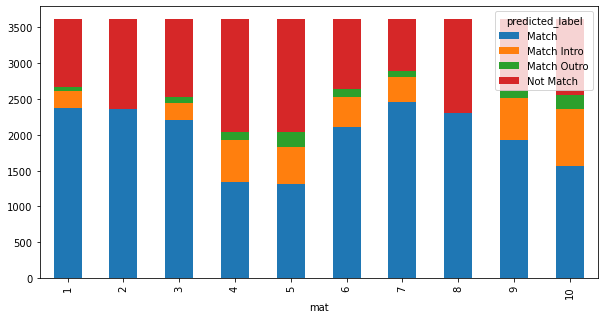

In [12]:
# first, let's get statistics on the predicted label
df["predicted_index"] = df.prob.apply(lambda x: np.argmax(x))
labels = df.iloc[0].labels
df["predicted_label"] = df.predicted_index.apply(lambda x: labels[x])
display(df.predicted_label.value_counts())

# now get the counts broken down by mat
df.groupby("mat").predicted_label.value_counts().unstack().plot(
    kind="bar", stacked=True, figsize=(10, 5)
)
# white face color
plt.gcf().set_facecolor("white")
plt.show()

In [9]:
# let's extract the probability into it's own column
for label in labels:
    df[label] = df.prob.apply(lambda x: x[labels.index(label)])
df.head()

,labels,path,prob,mat,batch_id,frame_id,timestamp,predicted_index,predicted_label,Match,Match Intro,Match Outro,Not Match
0,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.999988079071044, 3.390043048057123e-06, 5.8...",1,3,0,1800,0,Match,0.999988,0.000003,0.000006,0.000003
1,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.9999911785125731, 2.422540092084091e-06, 3....",1,3,1,1801,0,Match,0.999991,0.000002,0.000004,0.000003
2,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.999605238437652, 2.9151377020752992e-05, 5....",1,3,2,1802,0,Match,0.999605,0.000029,0.000058,0.000307
3,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.999572098255157, 1.4574363376596013e-05, 6....",1,3,3,1803,0,Match,0.999572,0.000015,0.000061,0.000352
4,"[Match, Match Intro, Match Outro, Not Match]",/mnt/cs-share/pradalier/tmp/judo/frames/mat_01...,"[0.9999667406082151, 1.423342951056838e-06, 5....",1,3,4,1804,0,Match,0.999967,0.000001,0.000005,0.000027


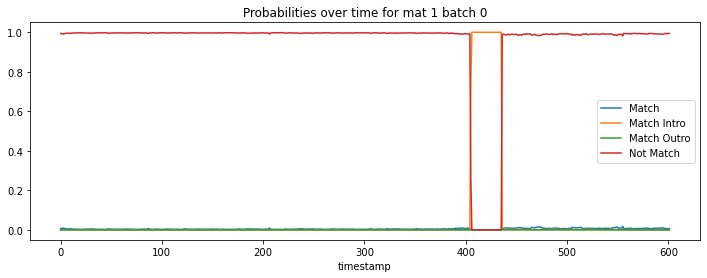

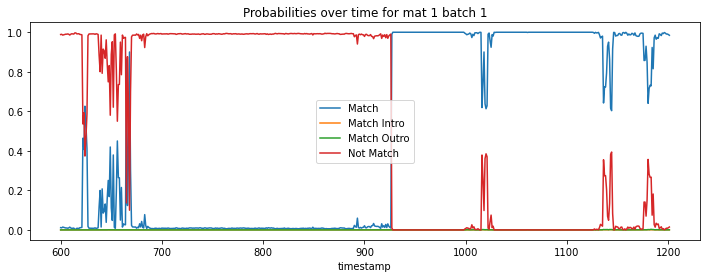

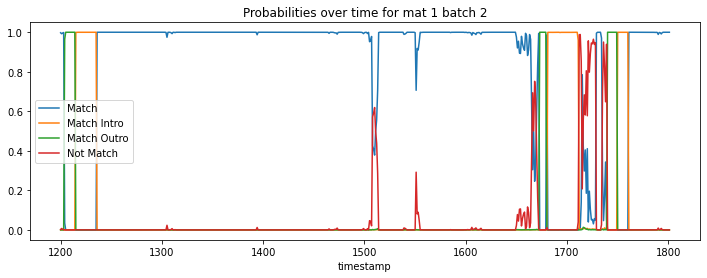

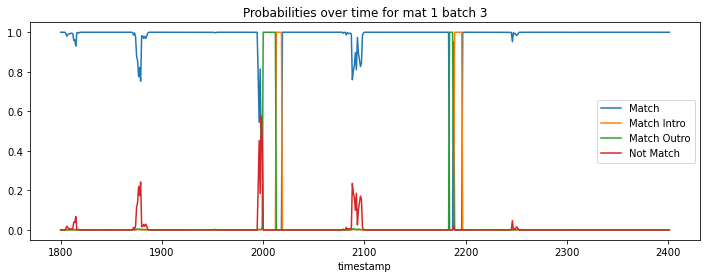

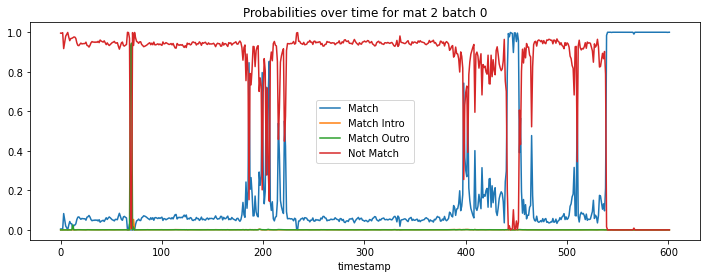

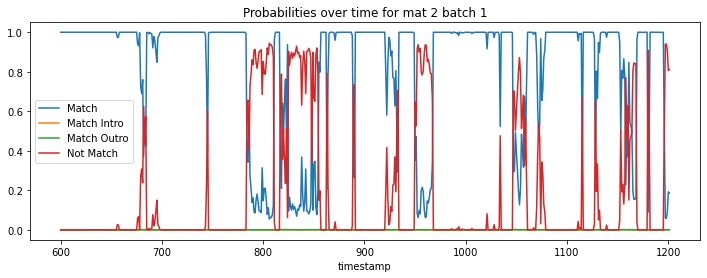

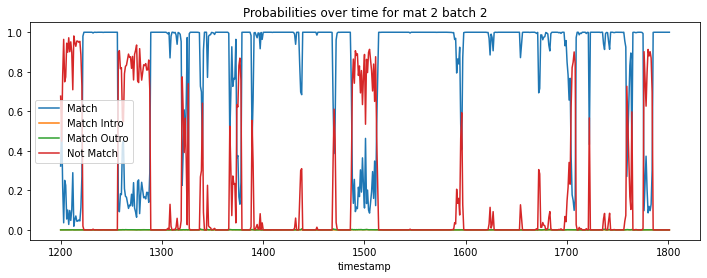

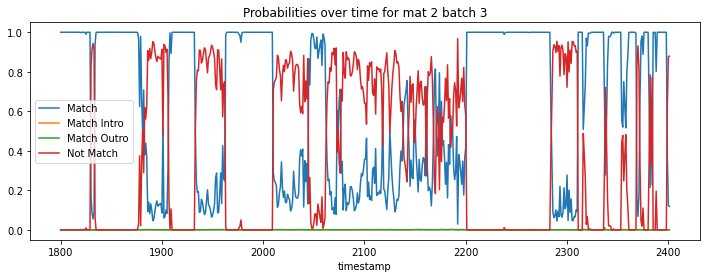

In [11]:
# let's now plot the probabilities for mat 1
for mat_id in [1, 2]:
    for batch_id in range(4):
        df_mat = (
            df[
                (df.mat == mat_id)
                # get the 3rd 10 minute interval
                & (df.batch_id == batch_id)
            ]
            .set_index("timestamp")
            .sort_index()
        )
        for label in labels:
            df_mat[label].plot(label=label, figsize=(12, 4))
        # set facecolor to white
        plt.gcf().set_facecolor("white")
        plt.legend()
        plt.title(f"Probabilities over time for mat {mat_id} batch {batch_id}")
        plt.show()